In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

(59500, 784)
(10500, 784)
(59500, 10)
(10500, 10)


In [ ]:
# Using the dataset from keras repository
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to hidden layer 3
        params['Z3'] = np.dot(params["W3"], params['A2'])
        # *** Use SOFTMAX for the final output (10 classes) ***
        params['A3'] = self.softmax(params['Z3']) # A3 is the final prediction, A7 is no longer used
        return params['A3']
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 3 to hidden layer 4
        params['Z4'] = np.dot(params["W4"], params['A3'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A4'] = self.sigmoid(params['Z4'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 4 to hidden layer 5
        params['Z5'] = np.dot(params["W5"], params['A4'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A5'] = self.sigmoid(params['Z5'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 5 to hidden layer 6
        params['Z6'] = np.dot(params["W6"], params['A5'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A6'] = self.sigmoid(params['Z6'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 6 to hidden layer 7
        params['Z7'] = np.dot(params["W7"], params['A6'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A7'] = self.softmax(params['Z7'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A7']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)



    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

Epoch: 1, Time Spent: 73.56s, Accuracy: 78.28%
Epoch: 1, Time Spent: 73.56s, Accuracy: 79.26%
Epoch: 1, Time Spent: 73.56s, loss: 0.06
Epoch: 1, Time Spent: 73.56s, loss: 0.00
-------------------------------------------------------------
Epoch: 2, Time Spent: 144.82s, Accuracy: 84.75%
Epoch: 2, Time Spent: 144.82s, Accuracy: 85.50%
Epoch: 2, Time Spent: 144.82s, loss: 0.03
Epoch: 2, Time Spent: 144.82s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 215.47s, Accuracy: 88.70%
Epoch: 3, Time Spent: 215.47s, Accuracy: 89.33%
Epoch: 3, Time Spent: 215.47s, loss: 0.03
Epoch: 3, Time Spent: 215.47s, loss: 0.01
-------------------------------------------------------------
Epoch: 4, Time Spent: 285.77s, Accuracy: 90.46%
Epoch: 4, Time Spent: 285.77s, Accuracy: 90.95%
Epoch: 4, Time Spent: 285.77s, loss: 0.03
Epoch: 4, Time Spent: 285.77s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 355.73s, Accur

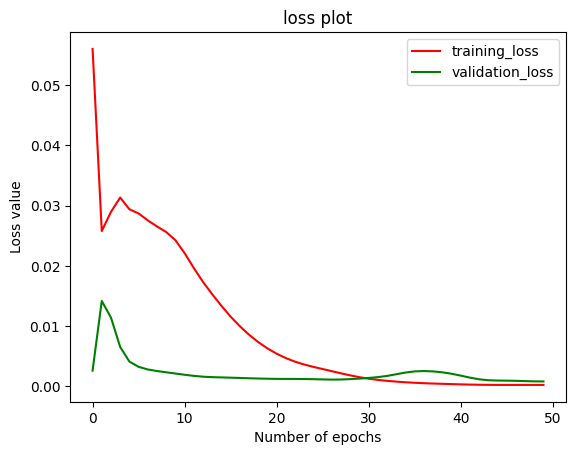

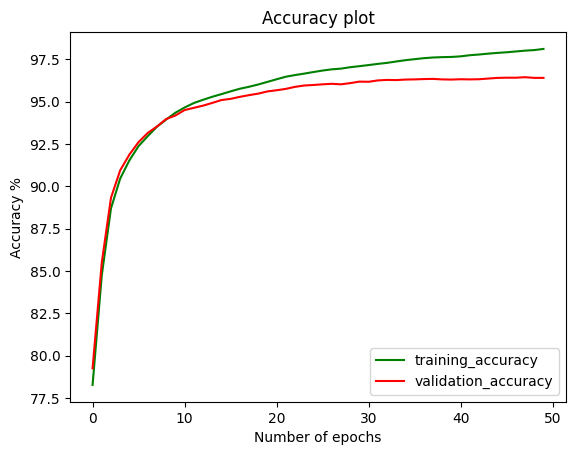

In [ ]:
dnn5 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=50, l_rate=0.05)
dnn5.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
#Reason
1.Enhanced Model Capacity (Increased text{sizes})The larger hidden layers ([784, 256,128, 10]) significantly increased the model's capacity compared to previous configurations
 The larger capacity allows the model to learn the complex features of the data more rapidly leading to the high overall accuracy (over 97% training, over 96% validation) achieved within just 50 epochs.
2.Balanced Learning Rate (l_rate=0.05)The learning rate is optimal for fast and stable convergence.
 It is high enough to ensure a rapid initial rise in accuracy ,but low enough to prevent the major fluctuations or oscillations seen with very high learning rates.
3. Quick Saturation/Sufficient Epochs :(epochs=50)By epoch 30, both curves begin to flatten out, indicating that the model has reached its maximum performance potential with these parameters.
  Running the model for more epochs would likely yield minimal additional gains, demonstrating that 50 epochs were sufficient to train the given architecture.
4.The model is performing slightly better on the training data, which is natural for a model with high capacity.
   However, because the gap is small and does not widen significantly toward the end, the overfitting is well-controlled


Epoch: 1, Time Spent: 72.30s, Accuracy: 63.41%
Epoch: 1, Time Spent: 72.30s, Accuracy: 63.36%
Epoch: 1, Time Spent: 72.30s, loss: 0.28
Epoch: 1, Time Spent: 72.30s, loss: 0.12
-------------------------------------------------------------
Epoch: 2, Time Spent: 144.81s, Accuracy: 70.66%
Epoch: 2, Time Spent: 144.81s, Accuracy: 70.74%
Epoch: 2, Time Spent: 144.81s, loss: 0.25
Epoch: 2, Time Spent: 144.81s, loss: 0.08
-------------------------------------------------------------
Epoch: 3, Time Spent: 216.96s, Accuracy: 75.91%
Epoch: 3, Time Spent: 216.96s, Accuracy: 76.52%
Epoch: 3, Time Spent: 216.96s, loss: 0.17
Epoch: 3, Time Spent: 216.96s, loss: 0.04
-------------------------------------------------------------
Epoch: 4, Time Spent: 287.72s, Accuracy: 77.54%
Epoch: 4, Time Spent: 287.72s, Accuracy: 78.27%
Epoch: 4, Time Spent: 287.72s, loss: 0.09
Epoch: 4, Time Spent: 287.72s, loss: 0.02
-------------------------------------------------------------
Epoch: 5, Time Spent: 359.69s, Accur

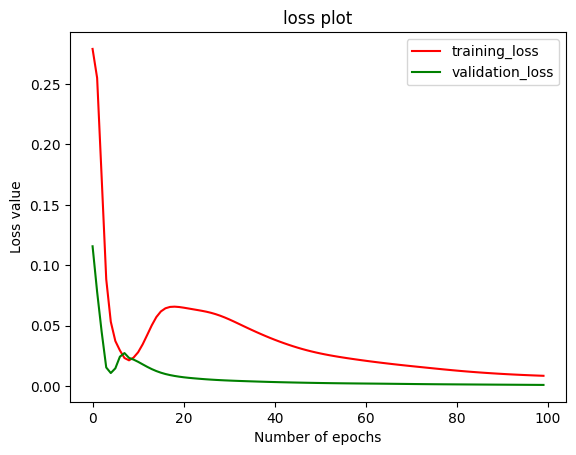

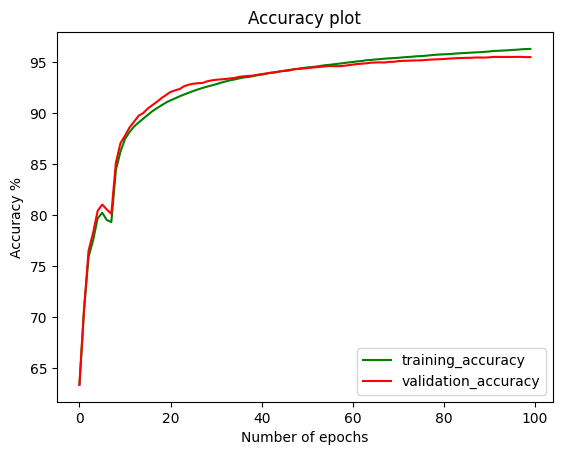

In [ ]:
dnn6 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=100, l_rate=0.01)
dnn6.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
#Reason
Optimized Learning RateThe learning rate :(l_rate=0.01) appears to be a good starting point for the training.
The rapid initial increase in accuracy (up to approx epoch 10) indicates that the model was quickly descending the loss landscape.
2.Minimal Overfitting
The plot shows that the training_accuracy and validation_accuracy curves are very close together throughout the entire 100 epochs,
with the validation accuracy only slightly lagging or dipping at certain points (e.g., around epoch 4-5).
This small gap is the key indicator of good generalization, meaning the model has learned general rules instead of memorizing the training data.
3.Sufficient Training Time
The model was trained for 100 epochs, and the accuracy curves are still slightly increasing up to the end.
This suggests the model was given enough time to learn the patterns in the data, leading to a high final accuracy (over 95%).
